<a href="https://colab.research.google.com/github/JanNogga/Vision_Systems_Lab/blob/main/Assignment_6/Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Notice

This notebook is just for training all of the models. It is not very interesting and badly documented. For formatted results, see *Assignment_6.ipynb*. After training was finished, the *trainer.fit()* calls were replaced with *trainer.load_model()*. Undo this if you want to re-train or produce the model parameters.

In [1]:
import numpy as np
import random as rand
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import os
import time
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
from trainer import Trainer
from models import VanillaVAE, ConvVAE
from utils import plot_history, reject_randomness, sample_interpolation
from kornia.losses import ssim_loss

/home/jannogga/anaconda3/envs/CudaLab/lib/python3.7/site-packages/kornia/augmentation/augmentation.py:1875: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  category=DeprecationWarning,


In [3]:
reject_randomness(2021)

/home/jannogga/anaconda3/envs/CudaLab/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
data_transforms = transforms.Compose([
    transforms.ToTensor()
])

trainset = dsets.CIFAR10('data', train=True, download=True, transform=data_transforms)
validset = dsets.CIFAR10('data', train=False, download=True, transform=data_transforms)

BATCH_SIZE = 128
train_loader = torch.utils.data.DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=14) 
valid_loader = torch.utils.data.DataLoader(dataset=validset, batch_size=BATCH_SIZE, shuffle=False, num_workers=14)

/home/jannogga/anaconda3/envs/CudaLab/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
#https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed
# def gaussian_likelihood(x, target):
#     recons, (z, mu, log_var, log_scale) = x
#     scale = torch.exp(log_scale)
#     mean = recons
#     dist = torch.distributions.normal.Normal(mean, scale)

#     log_pxz = dist.log_prob(target)
#     # flip sign because we want to maximize this
#     return -log_pxz.mean()

# def kl_divergence(x, target):
#     recons, (z, mu, log_var, log_scale) = x
#     std = torch.exp(0.5*log_var)
#     p = torch.distributions.normal.Normal(torch.zeros_like(mu), torch.ones_like(std))
#     q = torch.distributions.normal.Normal(mu, std)

#     log_q_z_given_x = q.log_prob(z)
#     log_p_z = p.log_prob(z)

#     kl = (log_q_z_given_x - log_p_z)
#     kl = kl.sum(-1)
#     return kl.mean()

def kl_loss(x, target):
    recons, (z, mu, log_var) = x
    return (mu**2 + log_var.exp() - 1 - log_var).mean() * 0.5

def reconstruction_loss(x, target):
    recons, (z, mu, log_var) = x
    #return nn.BCEWithLogitsLoss()(recons, target)
    x_hat = torch.sigmoid(recons)
    return F.smooth_l1_loss(x_hat,target)

def dssim(x, target):
    recons, (z, mu, log_var) = x
    x_hat = torch.sigmoid(recons)
    return ssim_loss(x_hat, target, 5)

# using https://github.com/chenyaofo/pytorch-cifar-models
# we assume these models are trained on normalized cifar images
# finally verified at https://github.com/chenyaofo/image-classification-codebase/blob/master/codebase/data/cifar.py
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
normalize = transforms.Normalize(mean, std)

def get_vgg_features():
    model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_vgg11_bn", pretrained=True)
    model.features.requires_grad_(False)
    return model.features

class PERCEPTUAL_LOSS(nn.Module):
    def __init__(self):
        super(PERCEPTUAL_LOSS, self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # get feature network from pretrained VGG
        self.features = get_vgg_features().to(self.device)
        # identifies the first 5 VGG blocks
        self.layers = [(0,3),(4,7),(8,10),(11,14),(15,17)]

    def forward(self, x, target):
        x_out, target_out = [], []
        (x_in, _), target_in = x, target
        x_in, target_in = normalize(torch.sigmoid(x_in)), normalize(target_in)
        # get feature maps for each layer, normalize and cache them
        for layer in self.layers:
            x_in = self.features[layer[0]:layer[1]+1](x_in)
            target_in = self.features[layer[0]:layer[1]+1](target_in)
            x_out.append(x_in / (torch.linalg.norm(x_in,dim=(-2,-1), keepdim=True) + 1e-12))
            target_out.append(target_in / (torch.linalg.norm(target_in,dim=(-2,-1), keepdim=True) + 1e-12))
        l = 0.
        # get weighted sum over feature map distances
        for i in range(len(x_out)):
            b, c, h, w = x_out[i].shape
            l += torch.sum((x_out[i]-target_out[i])**2, dim=(1,2,3))/(h*w)
        return l.mean()/len(x_out)

class VAE_CRITERION(nn.Module):
    def __init__(self, lambda_kl=1., lambda_r=1., lambda_p=0., lambda_dssim=0.):
        super(VAE_CRITERION, self).__init__()
        self.percept_loss = PERCEPTUAL_LOSS()
        self.lambda_kl = lambda_kl
        self.lambda_r = lambda_r
        self.lambda_p = lambda_p
        self.lambda_dssim = lambda_dssim
    def forward(self, x, target):
        recons_loss = reconstruction_loss(x, target)
        kl = kl_loss(x, target)
        if self.lambda_p > 0.:
            percept_loss = self.percept_loss(x, target)
        else:
            percept_loss = 0.
        if self.lambda_dssim > 0.:
            struct_loss = dssim(x, target)
        else:
            struct_loss = 0.
        loss = self.lambda_r*recons_loss + self.lambda_kl*kl + self.lambda_p*percept_loss + self.lambda_dssim*struct_loss
        return loss

# The subtext to figure 6 and section 'Understanding the effects of beta'
# https://openreview.net/pdf?id=Sy2fzU9gl
# suggests that the weight of the KL-term should be normalized with respect to latent and input dimensions.
# We believe this is a good appraoch, and observe that a high weight here will imediately collapse the model
# to zero KL loss, which comes at the cost of bad reconstruction performance.
BETA = 8
LATENT_DIM = 28
LR = 1e-4
criterion = VAE_CRITERION(lambda_kl=BETA*LATENT_DIM/(3*32*32), lambda_r=10., lambda_dssim=1., lambda_p=0)

/home/jannogga/anaconda3/envs/CudaLab/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Using cache found in /home/jannogga/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


In [6]:
eval_metrics = {
  "KL Loss": kl_loss,
  "Reconstruction Loss" : reconstruction_loss,
  "Perceptual Loss" : PERCEPTUAL_LOSS(),
  "DSSIM" : dssim
}

/home/jannogga/anaconda3/envs/CudaLab/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Using cache found in /home/jannogga/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


### Training 1 - ConvVAE with interpolate + conv upsample

The article at https://distill.pub/2016/deconv-checkerboard/ suggests that artifacts typically seen for transpose convolution layers could be avoided using upsampling and consecutive smoothing via one convolutional layer. Therefore, we also include this approach in our evaluation.

##### Training

/home/jannogga/anaconda3/envs/CudaLab/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Using cache found in /home/jannogga/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Number of model parameters with frozen encoder: 418293


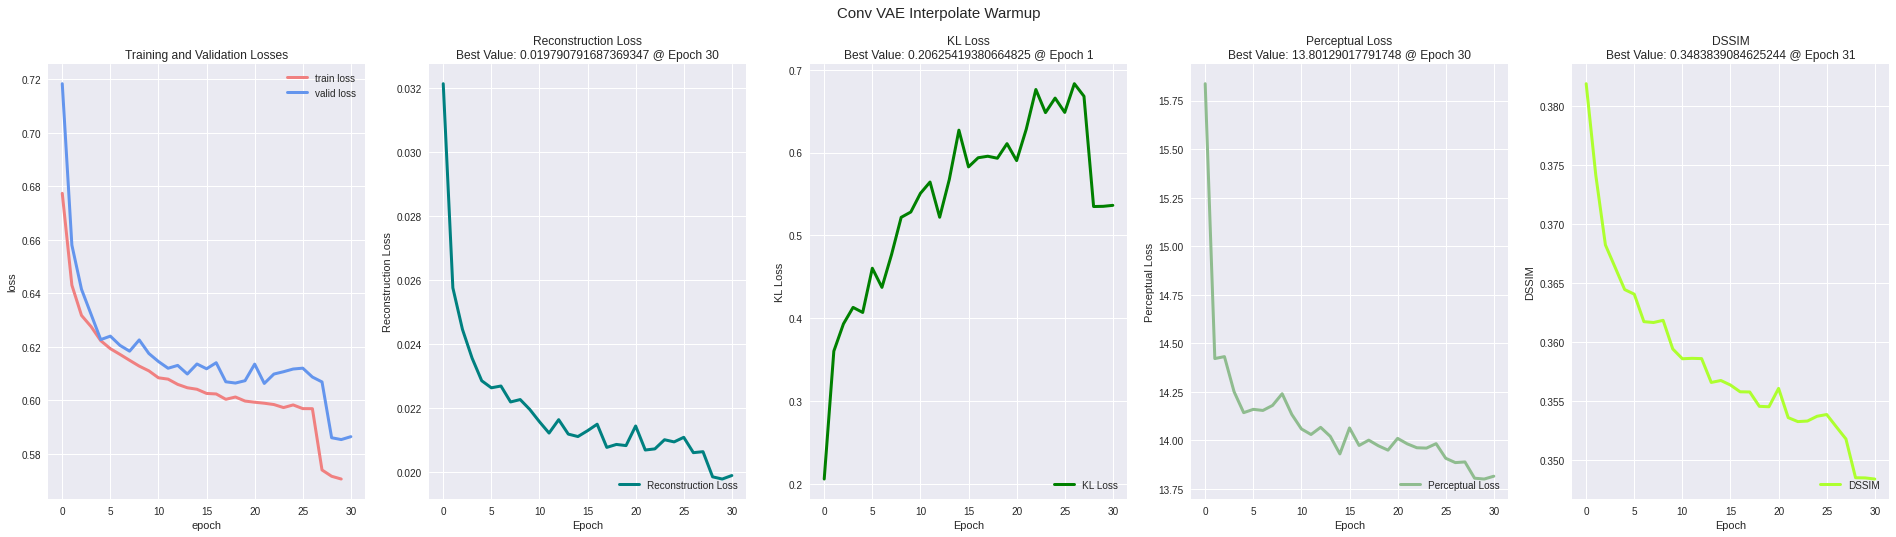

Number of model parameters: 690117


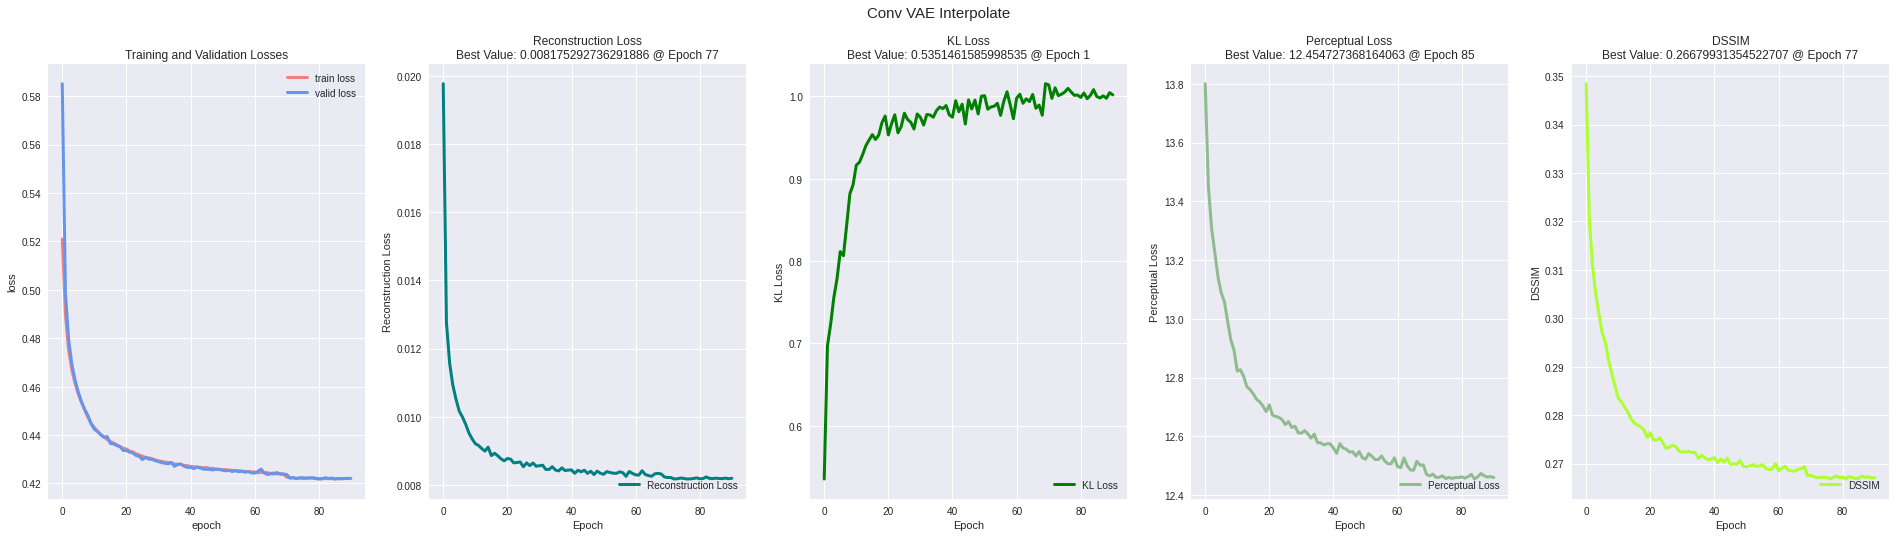

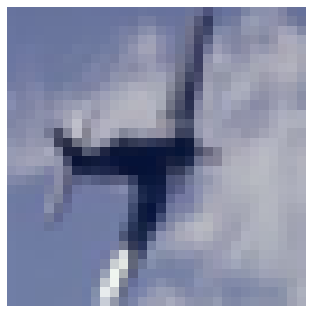

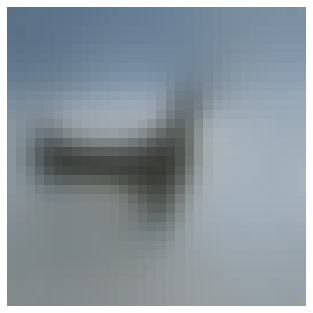

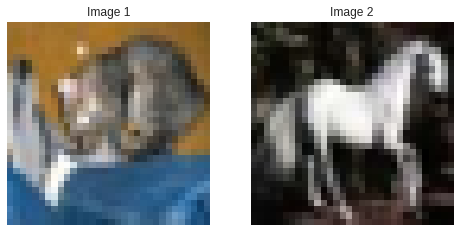

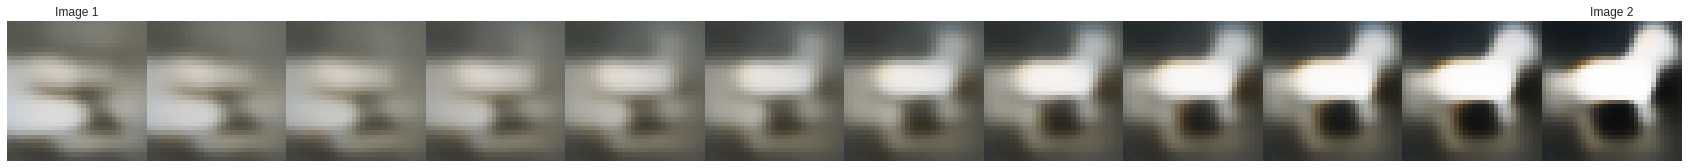

In [7]:
model = ConvVAE(z_dim=LATENT_DIM, mode='upConv')
model.freeze_encoder()

title = 'Conv VAE Interpolate'
print('Number of model parameters with frozen encoder:', sum(p.numel() for p in model.parameters() if p.requires_grad))
conv_vae_trainer_warmup = Trainer(model, criterion, train_loader, valid_loader, eval_metrics, description=title+' Warmup', lr=LR*10, n_epochs=30)
conv_vae_trainer_warmup.load_model()
plot_history(conv_vae_trainer_warmup)
model = conv_vae_trainer_warmup.model
model.unfreeze_encoder()
print('Number of model parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

conv_vae_trainer = Trainer(model, criterion, train_loader, valid_loader, eval_metrics, description=title, lr=LR)
conv_vae_trainer.load_model()
plot_history(conv_vae_trainer)

out = conv_vae_trainer.get_sample()
data, target, (x_hat, (z, mu, log_var)) = out
x_hat = nn.Sigmoid()(x_hat)
rand_index = np.random.randint(data.shape[0])
plt.imshow(data[rand_index].permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()
plt.imshow(x_hat.detach()[rand_index].permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()

img1, _ = validset[0]
img2, _ = validset[13]

plt.subplot(1,2,1)
plt.imshow(img1.unsqueeze(0).squeeze().permute(1, 2, 0))
plt.axis("off")
plt.title("Image 1")
plt.subplot(1,2,2)
plt.imshow(img2.unsqueeze(0).squeeze().permute(1, 2, 0))
plt.axis("off")
plt.title("Image 2")
plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    encoded = conv_vae_trainer.model.encoder(torch.stack([img1, img2]).to(device))
    mus, log_var = conv_vae_trainer.model.fc_mu(encoded), conv_vae_trainer.model.fc_sigma(encoded)
std = torch.exp(0.5*log_var)
latents = mus + std
latent1, latent2 = latents[0], latents[1]

decoded_imgs = sample_interpolation(conv_vae_trainer.model, latent2, latent1, N=12)
decoded_imgs = nn.Sigmoid()(decoded_imgs)

fig, ax = plt.subplots(1, len(decoded_imgs), figsize=(30,3))
for i,img in enumerate(decoded_imgs):
    ax[i].imshow(img.permute(1, 2, 0), cmap="gray")
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.subplots_adjust(wspace=0., hspace=0)
ax[0].set_title("Image 1")
ax[-1].set_title("Image 2")
plt.show()

### Training 2 - ConvVAE with PixelShuffle upsample

##### Training

/home/jannogga/anaconda3/envs/CudaLab/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Using cache found in /home/jannogga/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Number of model parameters with frozen encoder: 405637


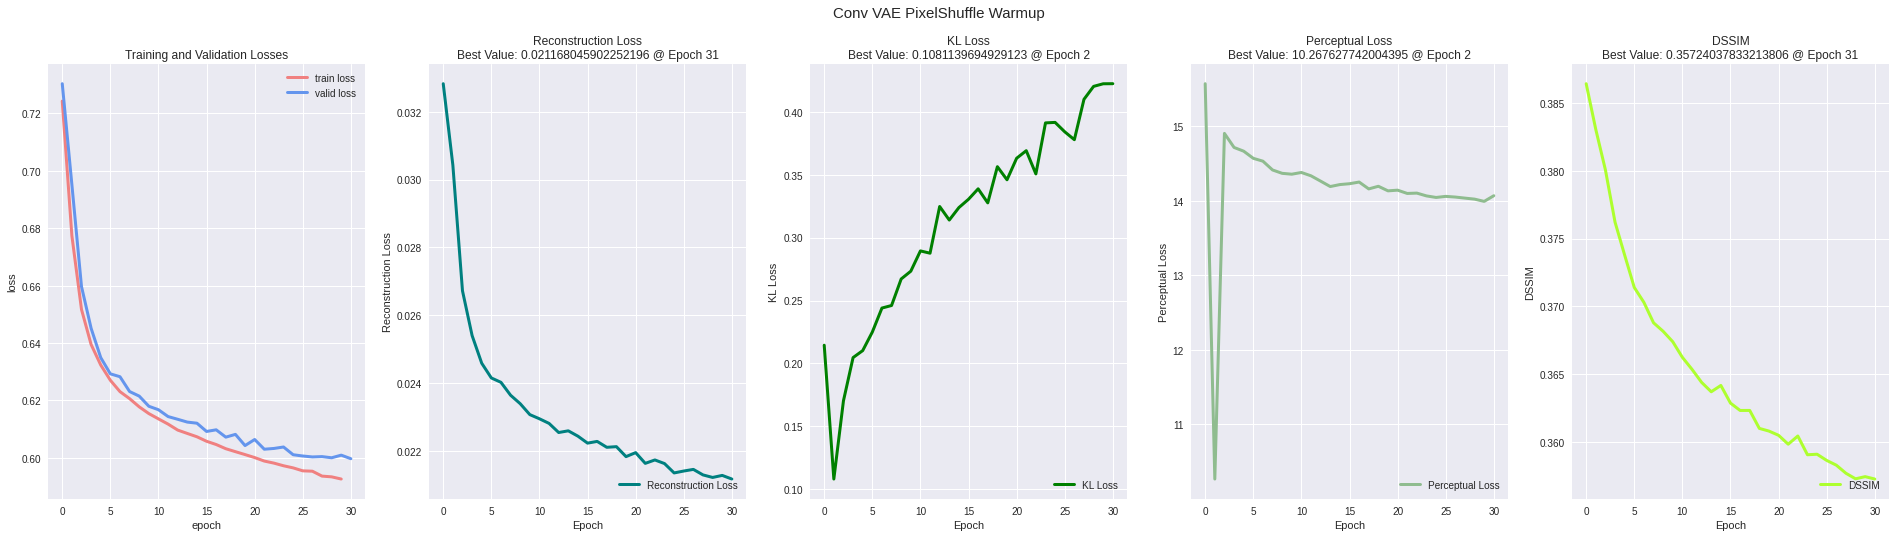

Number of model parameters: 677461


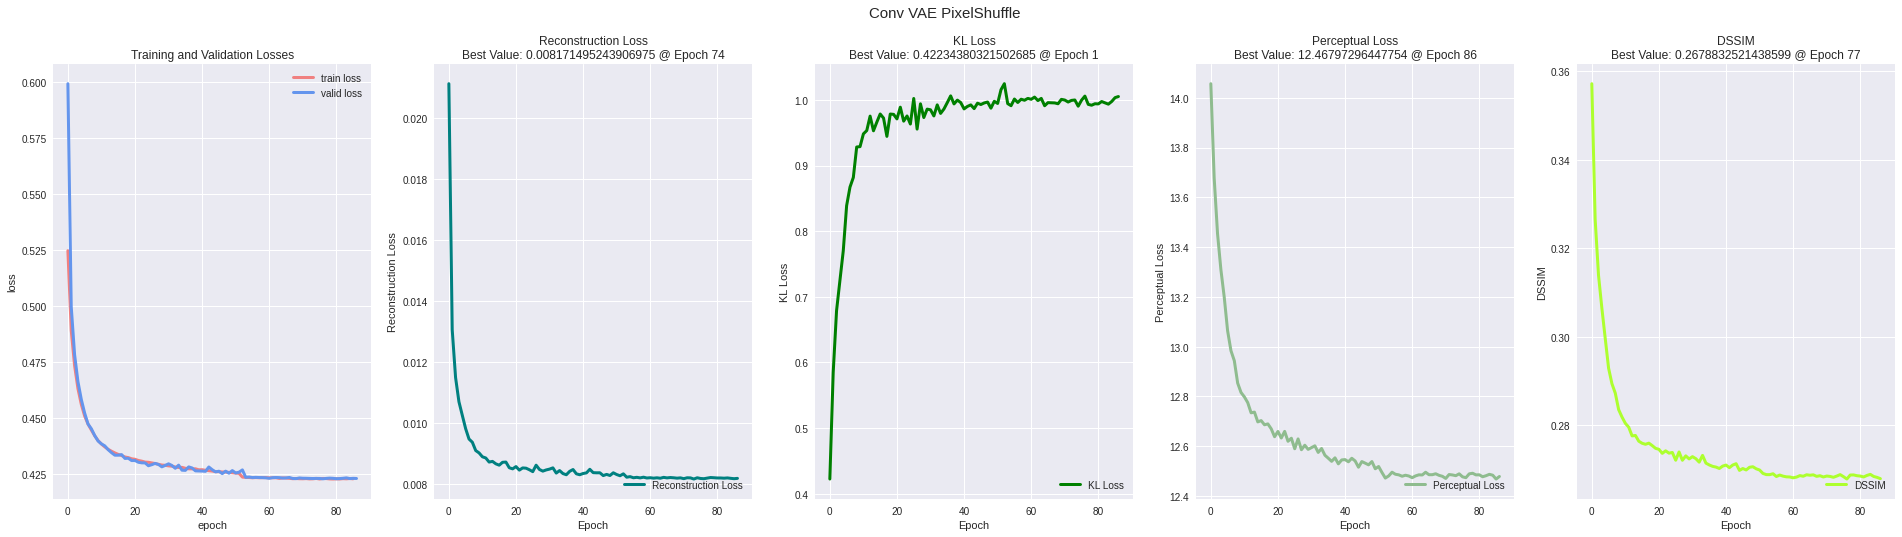

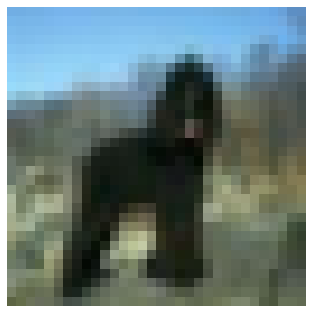

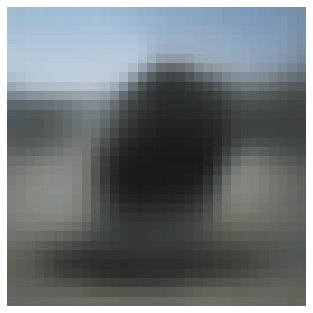

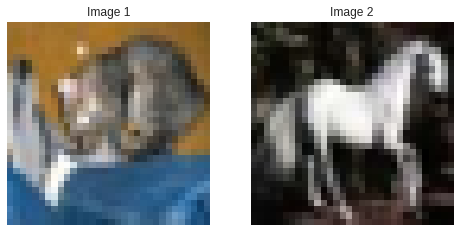

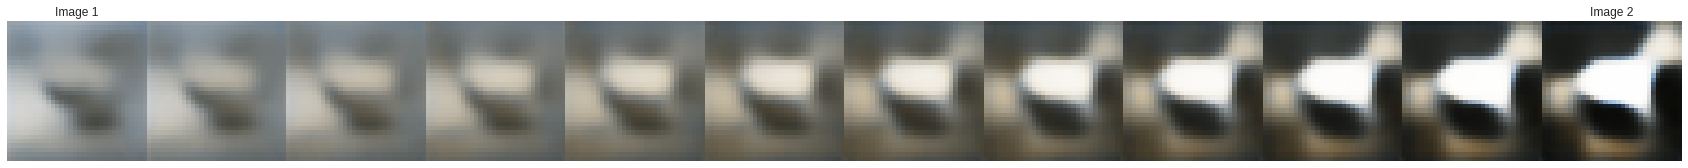

In [8]:
model = ConvVAE(z_dim=LATENT_DIM, mode='pixelShuffle')
model.freeze_encoder()

title = 'Conv VAE PixelShuffle'
print('Number of model parameters with frozen encoder:', sum(p.numel() for p in model.parameters() if p.requires_grad))
conv_vae_trainer_warmup = Trainer(model, criterion, train_loader, valid_loader, eval_metrics, description=title+' Warmup', lr=LR*2, n_epochs=30)
conv_vae_trainer_warmup.load_model()
plot_history(conv_vae_trainer_warmup)
model = conv_vae_trainer_warmup.model
model.unfreeze_encoder()
print('Number of model parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

conv_vae_trainer = Trainer(model, criterion, train_loader, valid_loader, eval_metrics, description=title, lr=LR)
conv_vae_trainer.load_model()
plot_history(conv_vae_trainer)

out = conv_vae_trainer.get_sample()
data, target, (x_hat, (z, mu, log_var)) = out
x_hat = nn.Sigmoid()(x_hat)
rand_index = np.random.randint(data.shape[0])
plt.imshow(data[rand_index].permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()
plt.imshow(x_hat.detach()[rand_index].permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()

img1, _ = validset[0]
img2, _ = validset[13]

plt.subplot(1,2,1)
plt.imshow(img1.unsqueeze(0).squeeze().permute(1, 2, 0))
plt.axis("off")
plt.title("Image 1")
plt.subplot(1,2,2)
plt.imshow(img2.unsqueeze(0).squeeze().permute(1, 2, 0))
plt.axis("off")
plt.title("Image 2")
plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    encoded = conv_vae_trainer.model.encoder(torch.stack([img1, img2]).to(device))
    mus, log_var = conv_vae_trainer.model.fc_mu(encoded), conv_vae_trainer.model.fc_sigma(encoded)
std = torch.exp(0.5*log_var)
latents = mus + std
latent1, latent2 = latents[0], latents[1]

decoded_imgs = sample_interpolation(conv_vae_trainer.model, latent2, latent1, N=12)
decoded_imgs = nn.Sigmoid()(decoded_imgs)

fig, ax = plt.subplots(1, len(decoded_imgs), figsize=(30,3))
for i,img in enumerate(decoded_imgs):
    ax[i].imshow(img.permute(1, 2, 0), cmap="gray")
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.subplots_adjust(wspace=0., hspace=0)
ax[0].set_title("Image 1")
ax[-1].set_title("Image 2")
plt.show()

### Training 3 - ConvVAE with transpose conv upsample
##### Training

/home/jannogga/anaconda3/envs/CudaLab/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Using cache found in /home/jannogga/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Number of model parameters with frozen encoder: 397813


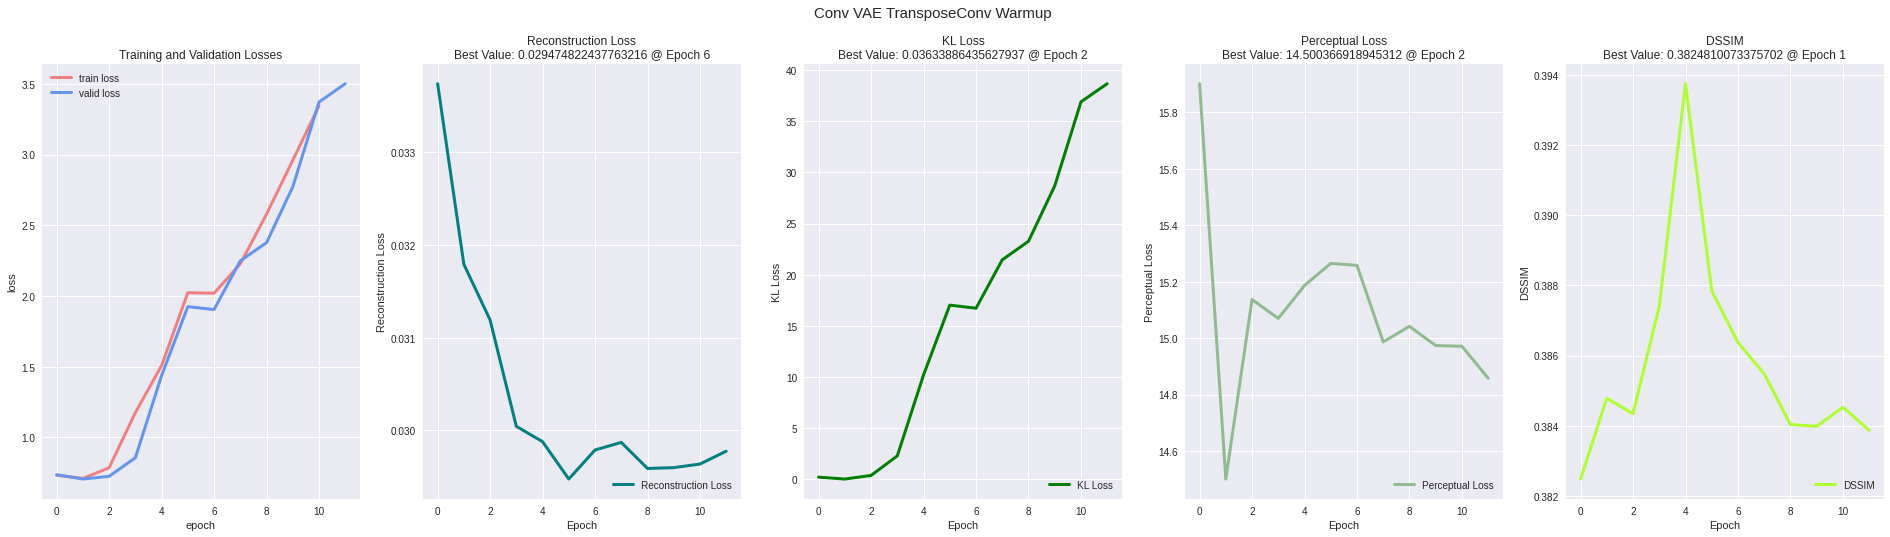

Number of model parameters: 669637


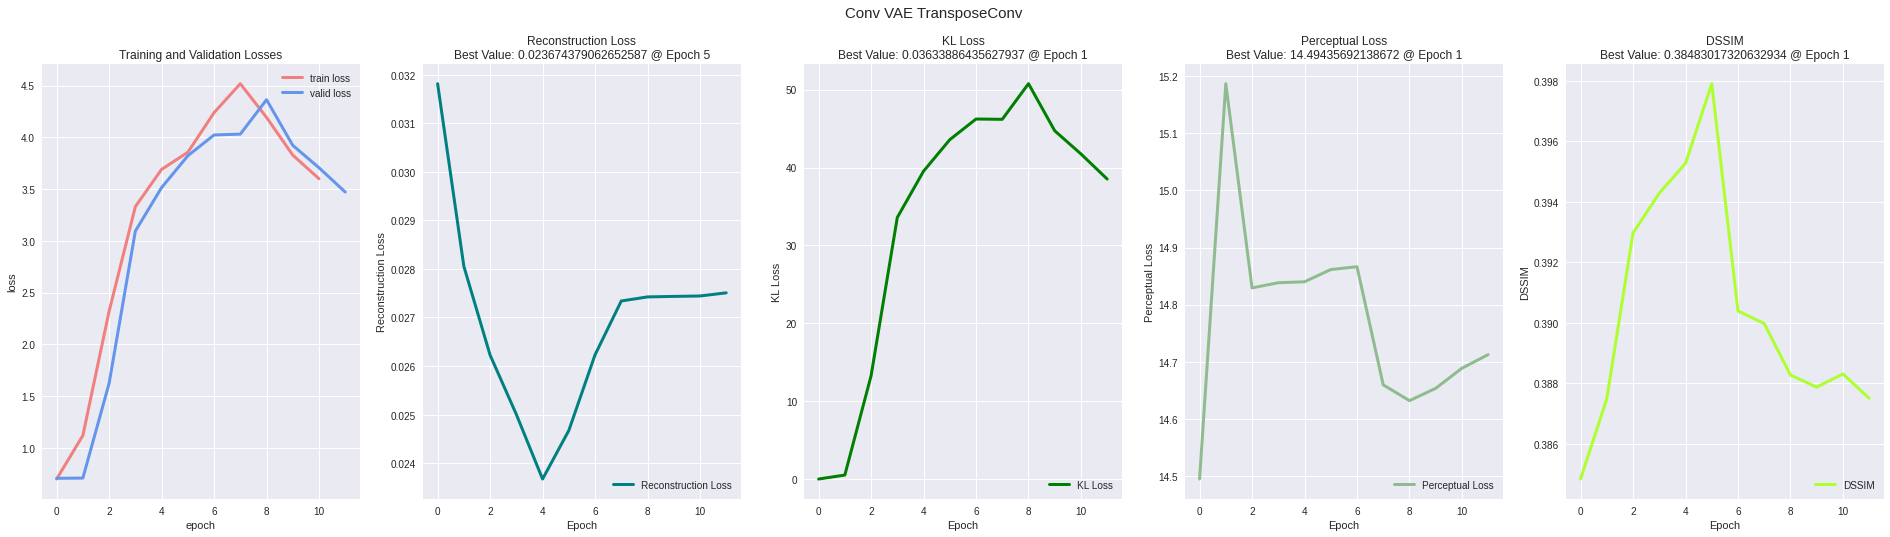

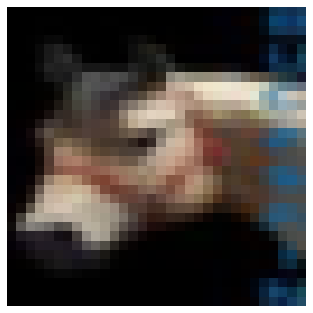

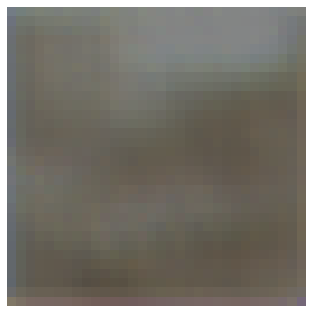

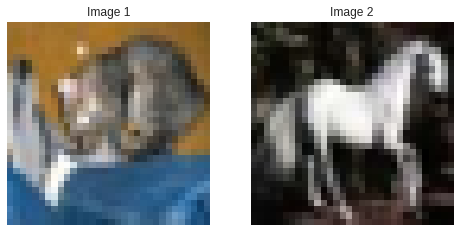

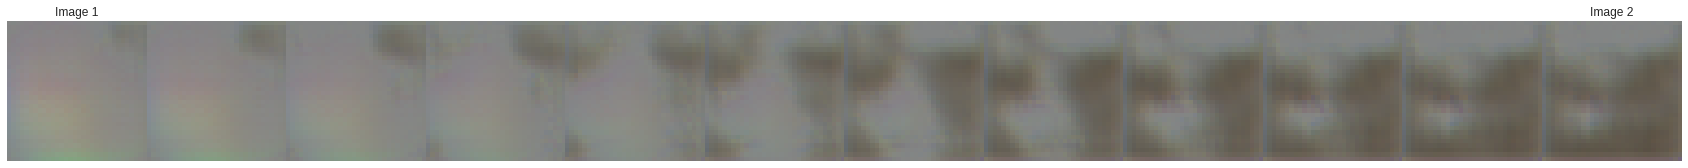

In [9]:
model = ConvVAE(z_dim=LATENT_DIM, mode='deConv')
model.freeze_encoder()

title = 'Conv VAE TransposeConv'
print('Number of model parameters with frozen encoder:', sum(p.numel() for p in model.parameters() if p.requires_grad))
conv_vae_trainer_warmup = Trainer(model, criterion, train_loader, valid_loader, eval_metrics, description=title+' Warmup', lr=LR*2, n_epochs=30)
conv_vae_trainer_warmup.load_model()
plot_history(conv_vae_trainer_warmup)
model = conv_vae_trainer_warmup.model
model.unfreeze_encoder()
print('Number of model parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

conv_vae_trainer = Trainer(model, criterion, train_loader, valid_loader, eval_metrics, description=title, lr=LR)
conv_vae_trainer.load_model()
plot_history(conv_vae_trainer)

out = conv_vae_trainer.get_sample()
data, target, (x_hat, (z, mu, log_var)) = out
x_hat = nn.Sigmoid()(x_hat)
rand_index = np.random.randint(data.shape[0])
plt.imshow(data[rand_index].permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()
plt.imshow(x_hat.detach()[rand_index].permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()

img1, _ = validset[0]
img2, _ = validset[13]

plt.subplot(1,2,1)
plt.imshow(img1.unsqueeze(0).squeeze().permute(1, 2, 0))
plt.axis("off")
plt.title("Image 1")
plt.subplot(1,2,2)
plt.imshow(img2.unsqueeze(0).squeeze().permute(1, 2, 0))
plt.axis("off")
plt.title("Image 2")
plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    encoded = conv_vae_trainer.model.encoder(torch.stack([img1, img2]).to(device))
    mus, log_var = conv_vae_trainer.model.fc_mu(encoded), conv_vae_trainer.model.fc_sigma(encoded)
std = torch.exp(0.5*log_var)
latents = mus + std
latent1, latent2 = latents[0], latents[1]

decoded_imgs = sample_interpolation(conv_vae_trainer.model, latent2, latent1, N=12)
decoded_imgs = nn.Sigmoid()(decoded_imgs)

fig, ax = plt.subplots(1, len(decoded_imgs), figsize=(30,3))
for i,img in enumerate(decoded_imgs):
    ax[i].imshow(img.permute(1, 2, 0), cmap="gray")
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.subplots_adjust(wspace=0., hspace=0)
ax[0].set_title("Image 1")
ax[-1].set_title("Image 2")
plt.show()

### Training 4 - VAE from Class

##### Training

/home/jannogga/anaconda3/envs/CudaLab/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Number of model parameters: 3291960


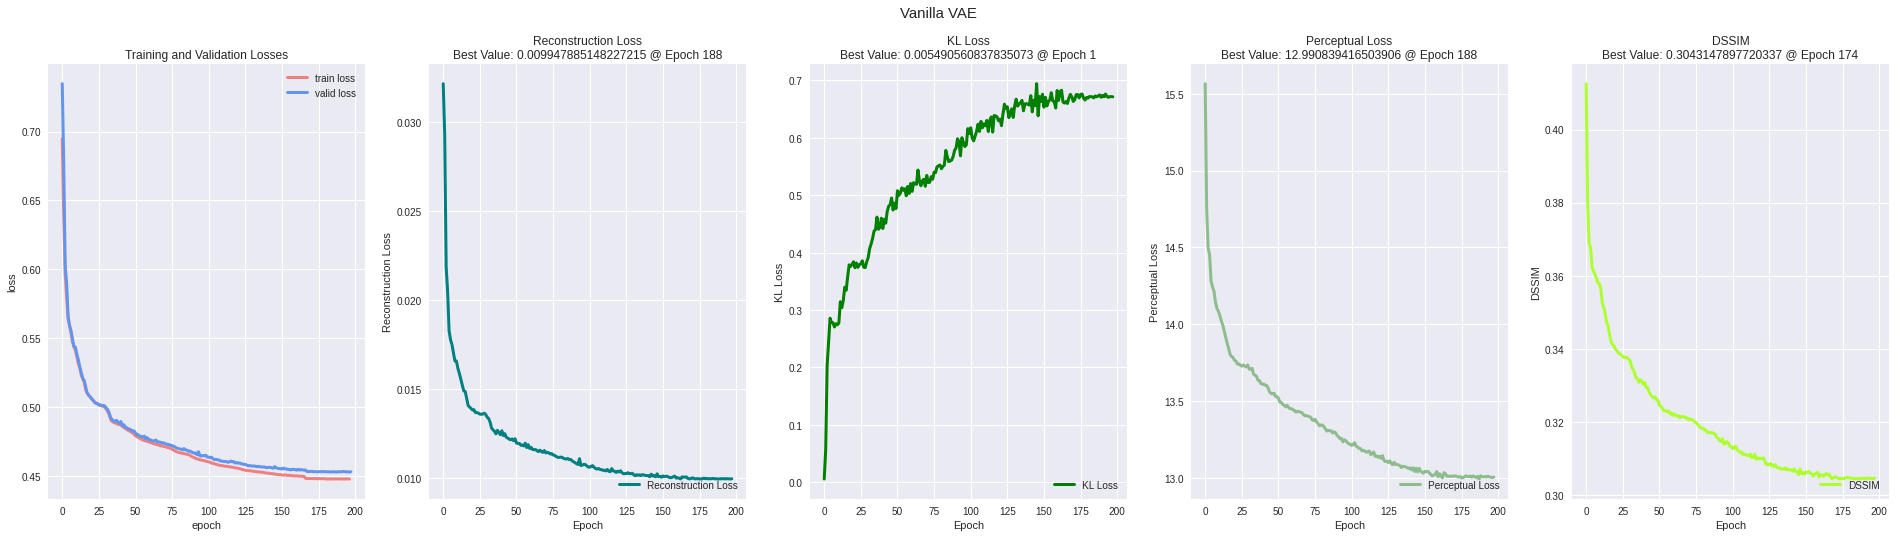

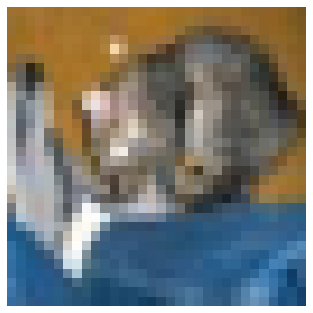

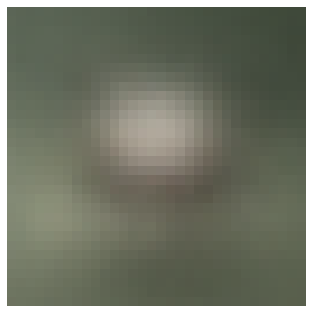

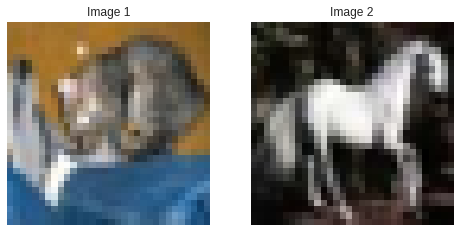

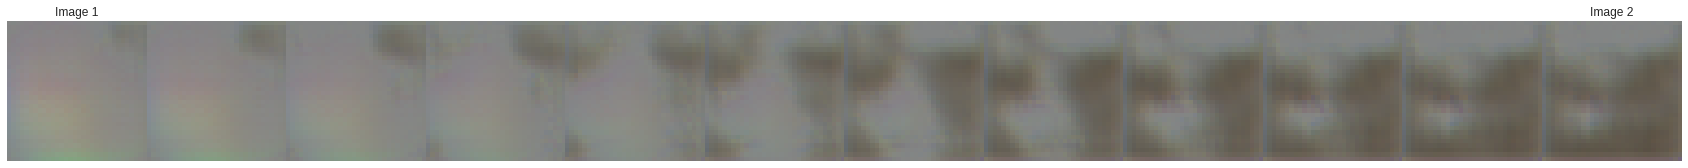

In [10]:
from models import VanillaVAE
model = VanillaVAE(in_size=(3,32,32), sizes=[3072, 512, 128, LATENT_DIM], act="ReLU")
print('Number of model parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

title = 'Vanilla VAE'
vanilla_vae_trainer = Trainer(model, criterion, train_loader, valid_loader, eval_metrics, es_mode='min', description=title, lr=LR)
vanilla_vae_trainer.load_model()
plot_history(vanilla_vae_trainer)

out = vanilla_vae_trainer.get_sample()
data, target, (x_hat, (z, mu, log_var)) = out

x_hat = nn.Sigmoid()(x_hat)
rand_index = np.random.randint(data.shape[0])
plt.imshow(data[rand_index].permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()
plt.imshow(x_hat.detach()[rand_index].permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()

img1, _ = validset[0]
img2, _ = validset[13]

plt.subplot(1,2,1)
plt.imshow(img1.unsqueeze(0).squeeze().permute(1, 2, 0))
plt.axis("off")
plt.title(f"Image 1")
plt.subplot(1,2,2)
plt.imshow(img2.unsqueeze(0).squeeze().permute(1, 2, 0))
plt.axis("off")
plt.title(f"Image 2")
plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    encoded = conv_vae_trainer.model.encoder(torch.stack([img1, img2]).to(device))
    mus, log_var = conv_vae_trainer.model.fc_mu(encoded), conv_vae_trainer.model.fc_sigma(encoded)
std = torch.exp(0.5*log_var)
latents = mus + std
latent1, latent2 = latents[0], latents[1]

decoded_imgs = sample_interpolation(conv_vae_trainer.model, latent2, latent1, N=12)
decoded_imgs = nn.Sigmoid()(decoded_imgs)

fig, ax = plt.subplots(1, len(decoded_imgs), figsize=(30,3))
for i,img in enumerate(decoded_imgs):
    ax[i].imshow(img.permute(1, 2, 0), cmap="gray")
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.subplots_adjust(wspace=0., hspace=0)
ax[0].set_title("Image 1")
ax[-1].set_title("Image 2")
plt.show()

### Training 5 - Retraining a Model optimizing Perceptual Loss

Number of model parameters with frozen encoder: 418293


/home/jannogga/anaconda3/envs/CudaLab/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Using cache found in /home/jannogga/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/jannogga/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


  0%|          | 0/30 [00:00<?, ?it/s]

Early stopping triggered!


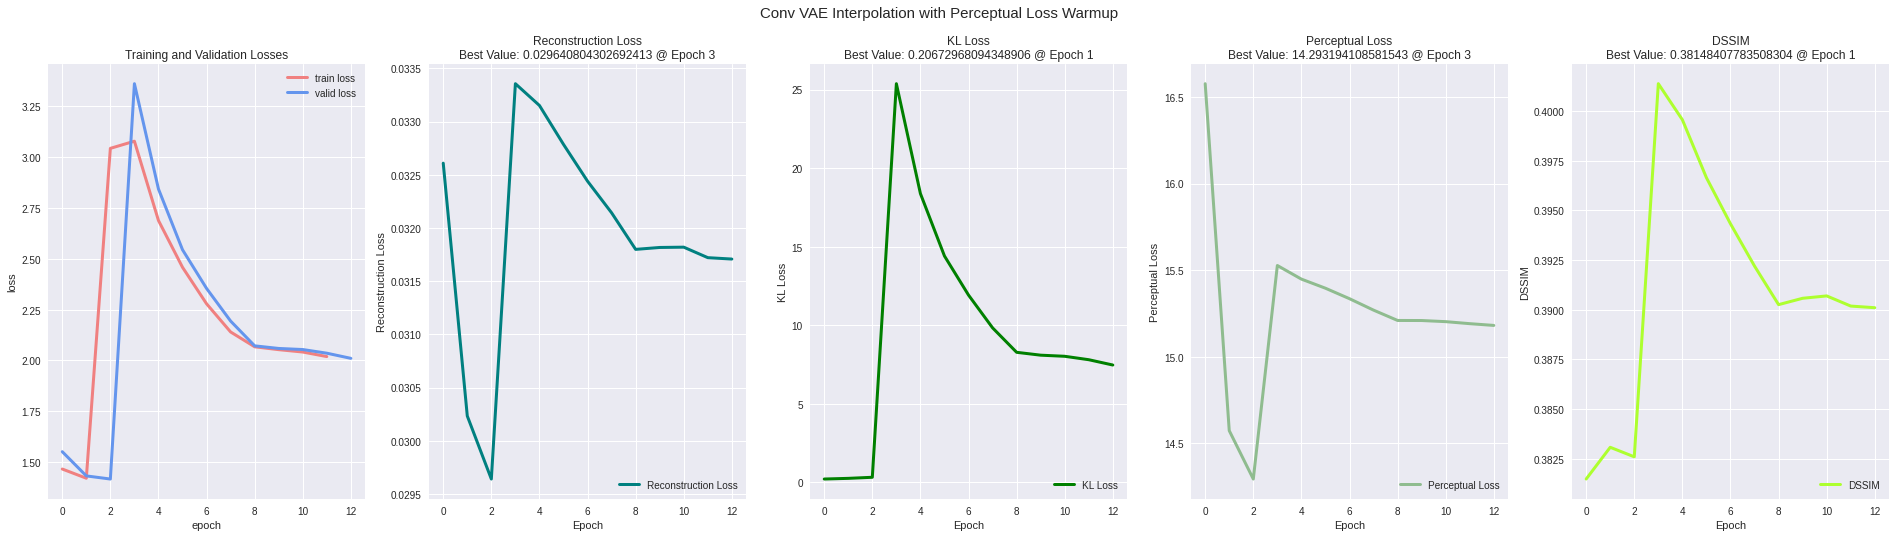

Number of model parameters: 690117


  0%|          | 0/250 [00:00<?, ?it/s]

Early stopping triggered!


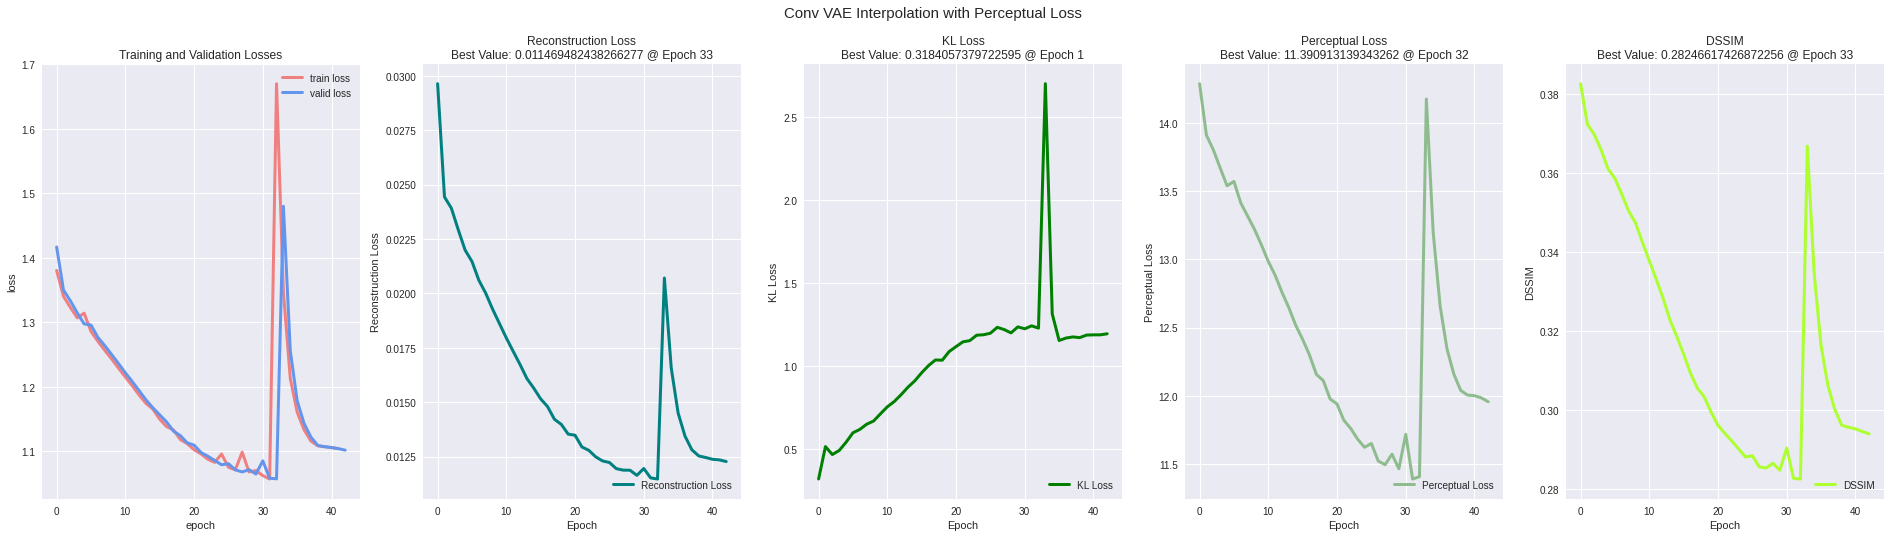

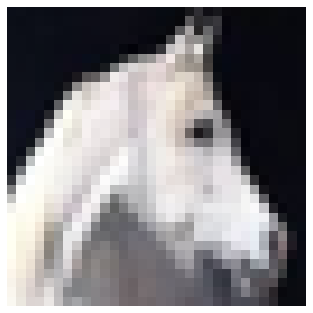

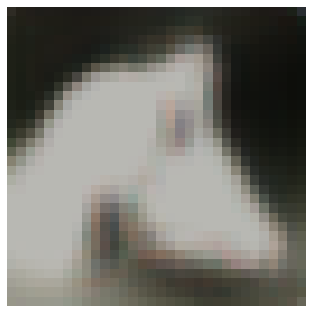

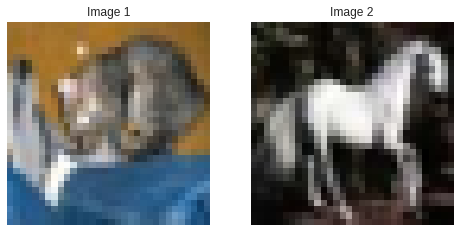

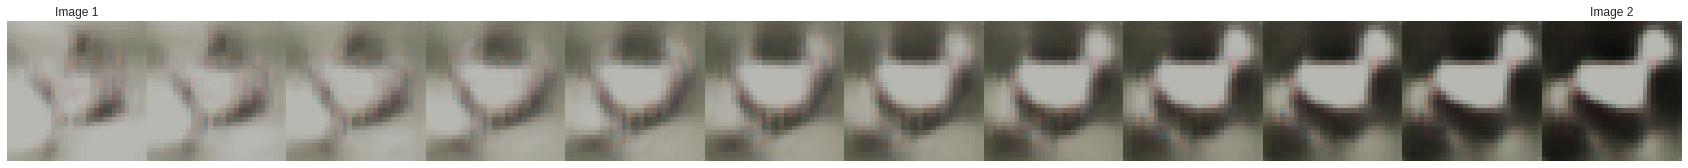

In [11]:
criterion = VAE_CRITERION(lambda_kl=BETA*LATENT_DIM/(3*32*32), lambda_r=10., lambda_dssim=1., lambda_p=0.05)

model = ConvVAE(z_dim=LATENT_DIM, mode='upConv')
model.freeze_encoder()

title = 'Conv VAE Interpolation with Perceptual Loss'
print('Number of model parameters with frozen encoder:', sum(p.numel() for p in model.parameters() if p.requires_grad))
conv_vae_trainer_warmup = Trainer(model, criterion, train_loader, valid_loader, eval_metrics, description=title+' Warmup', lr=LR*2, n_epochs=30)
conv_vae_trainer_warmup.load_model()
plot_history(conv_vae_trainer_warmup)
model = conv_vae_trainer_warmup.model
model.unfreeze_encoder()
print('Number of model parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

conv_vae_trainer = Trainer(model, criterion, train_loader, valid_loader, eval_metrics, description=title, lr=LR)
conv_vae_trainer.load_model()
plot_history(conv_vae_trainer)

out = conv_vae_trainer.get_sample()
data, target, (x_hat, (z, mu, log_var)) = out
x_hat = nn.Sigmoid()(x_hat)
rand_index = np.random.randint(data.shape[0])
plt.imshow(data[rand_index].permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()
plt.imshow(x_hat.detach()[rand_index].permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()

img1, _ = validset[0]
img2, _ = validset[13]

plt.subplot(1,2,1)
plt.imshow(img1.unsqueeze(0).squeeze().permute(1, 2, 0))
plt.axis("off")
plt.title("Image 1")
plt.subplot(1,2,2)
plt.imshow(img2.unsqueeze(0).squeeze().permute(1, 2, 0))
plt.axis("off")
plt.title("Image 2")
plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    encoded = conv_vae_trainer.model.encoder(torch.stack([img1, img2]).to(device))
    mus, log_var = conv_vae_trainer.model.fc_mu(encoded), conv_vae_trainer.model.fc_sigma(encoded)
std = torch.exp(0.5*log_var)
latents = mus + std
latent1, latent2 = latents[0], latents[1]

decoded_imgs = sample_interpolation(conv_vae_trainer.model, latent2, latent1, N=12)
decoded_imgs = nn.Sigmoid()(decoded_imgs)

fig, ax = plt.subplots(1, len(decoded_imgs), figsize=(30,3))
for i,img in enumerate(decoded_imgs):
    ax[i].imshow(img.permute(1, 2, 0), cmap="gray")
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.subplots_adjust(wspace=0., hspace=0)
ax[0].set_title("Image 1")
ax[-1].set_title("Image 2")
plt.show()

### Training 6 - Retraining a Model optimizing Perceptual Loss

/home/jannogga/anaconda3/envs/CudaLab/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
Using cache found in /home/jannogga/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master
Using cache found in /home/jannogga/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Number of model parameters with frozen encoder: 418293


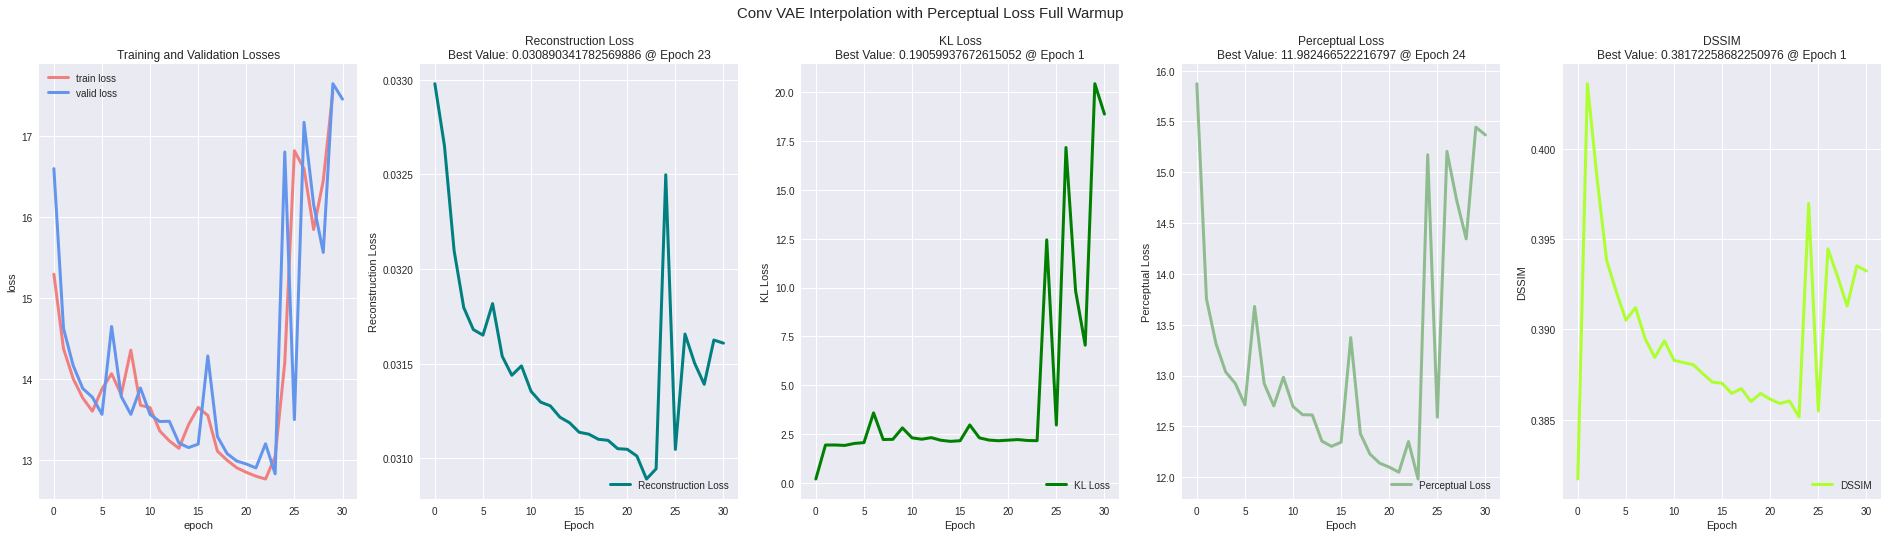

Number of model parameters: 690117


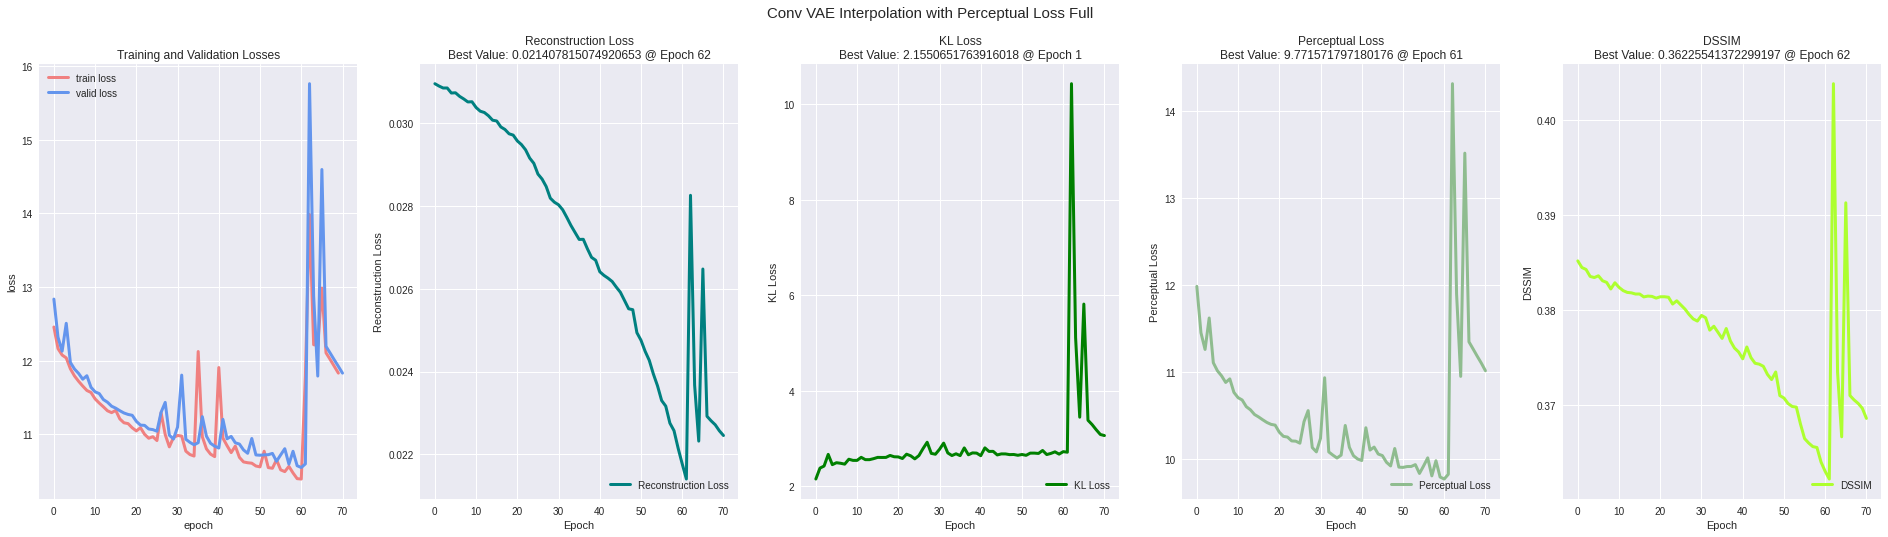

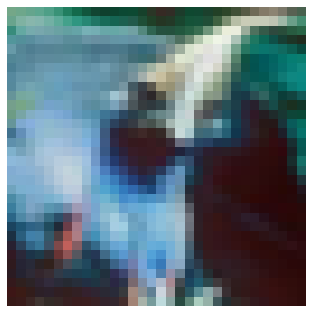

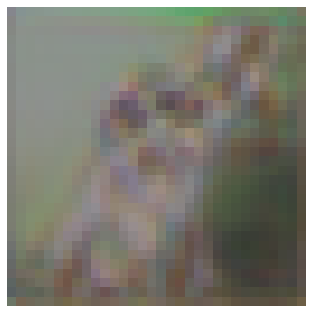

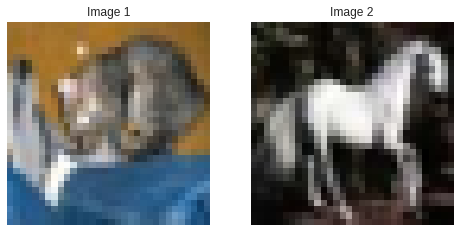

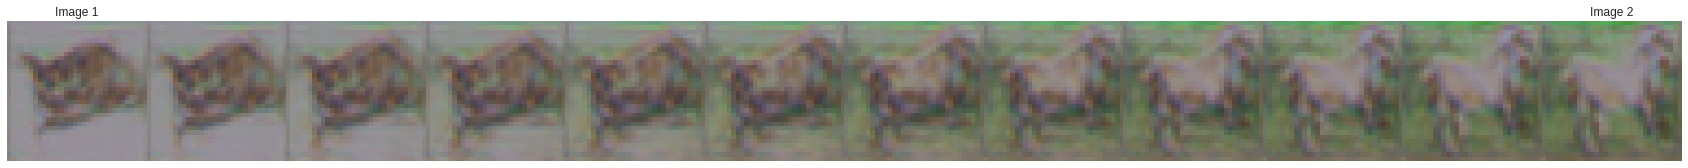

In [15]:
criterion = VAE_CRITERION(lambda_kl=BETA*LATENT_DIM/(3*32*32), lambda_r=10., lambda_dssim=1., lambda_p=1.)

model = ConvVAE(z_dim=LATENT_DIM, mode='upConv')
model.freeze_encoder()

title = 'Conv VAE Interpolation with Perceptual Loss Full'
print('Number of model parameters with frozen encoder:', sum(p.numel() for p in model.parameters() if p.requires_grad))
conv_vae_trainer_warmup = Trainer(model, criterion, train_loader, valid_loader, eval_metrics, description=title+' Warmup', lr=LR*2, n_epochs=30)
conv_vae_trainer_warmup.load_model()
plot_history(conv_vae_trainer_warmup)
model = conv_vae_trainer_warmup.model
model.unfreeze_encoder()
print('Number of model parameters:', sum(p.numel() for p in model.parameters() if p.requires_grad))

conv_vae_trainer = Trainer(model, criterion, train_loader, valid_loader, eval_metrics, description=title, lr=LR)
conv_vae_trainer.load_model()
plot_history(conv_vae_trainer)

out = conv_vae_trainer.get_sample()
data, target, (x_hat, (z, mu, log_var)) = out
x_hat = nn.Sigmoid()(x_hat)
rand_index = np.random.randint(data.shape[0])
plt.imshow(data[rand_index].permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()
plt.imshow(x_hat.detach()[rand_index].permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()

img1, _ = validset[0]
img2, _ = validset[13]

plt.subplot(1,2,1)
plt.imshow(img1.unsqueeze(0).squeeze().permute(1, 2, 0))
plt.axis("off")
plt.title("Image 1")
plt.subplot(1,2,2)
plt.imshow(img2.unsqueeze(0).squeeze().permute(1, 2, 0))
plt.axis("off")
plt.title("Image 2")
plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    encoded = conv_vae_trainer.model.encoder(torch.stack([img1, img2]).to(device))
    mus, log_var = conv_vae_trainer.model.fc_mu(encoded), conv_vae_trainer.model.fc_sigma(encoded)
std = torch.exp(0.5*log_var)
latents = mus + std
latent1, latent2 = latents[0], latents[1]

decoded_imgs = sample_interpolation(conv_vae_trainer.model, latent2, latent1, N=12)
decoded_imgs = nn.Sigmoid()(decoded_imgs)

fig, ax = plt.subplots(1, len(decoded_imgs), figsize=(30,3))
for i,img in enumerate(decoded_imgs):
    ax[i].imshow(img.permute(1, 2, 0), cmap="gray")
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.subplots_adjust(wspace=0., hspace=0)
ax[0].set_title("Image 1")
ax[-1].set_title("Image 2")
plt.show()

/home/jannogga/anaconda3/envs/CudaLab/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


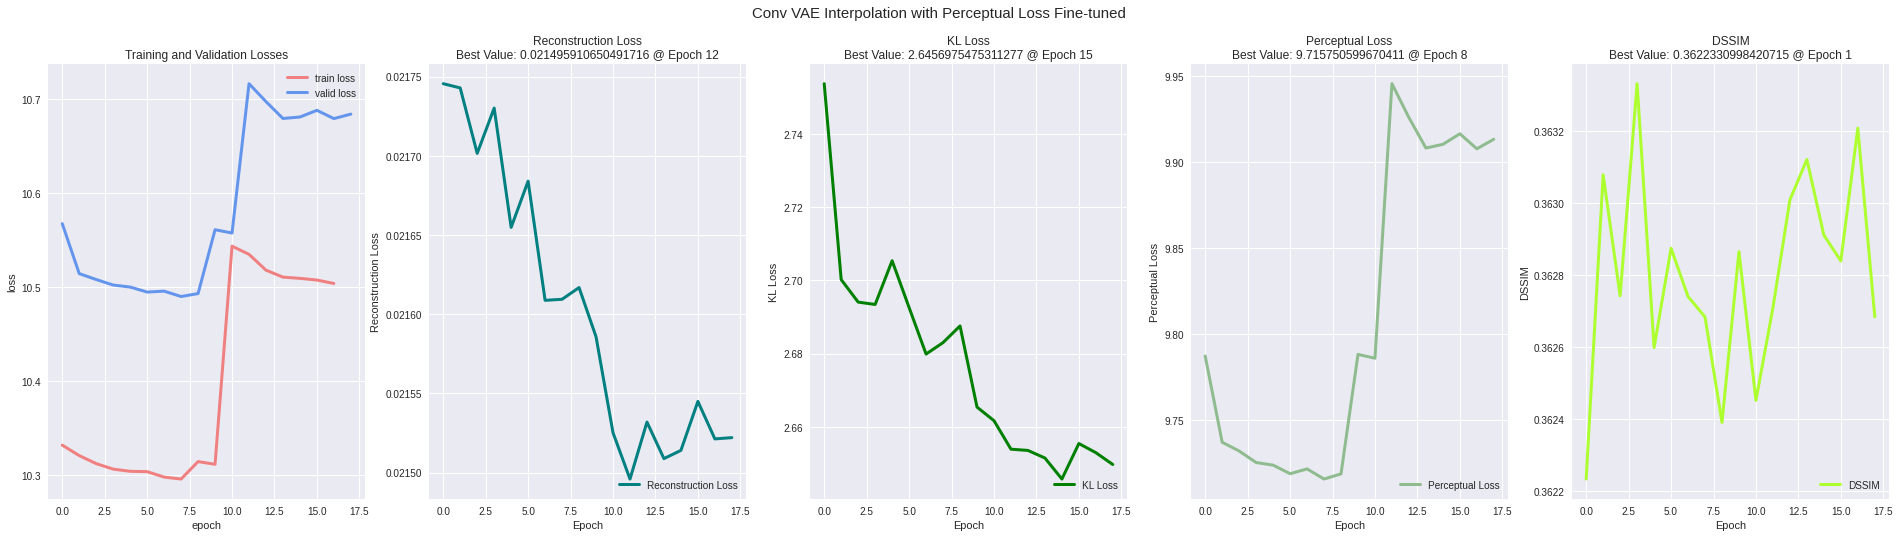

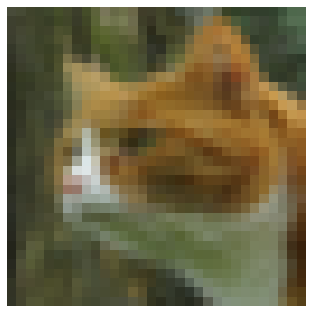

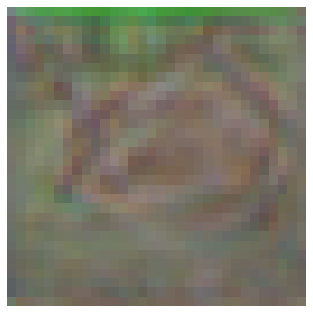

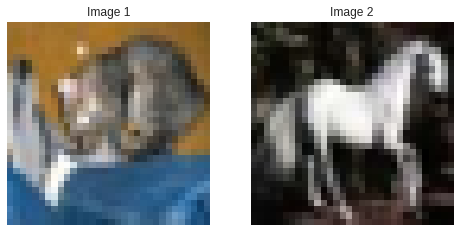

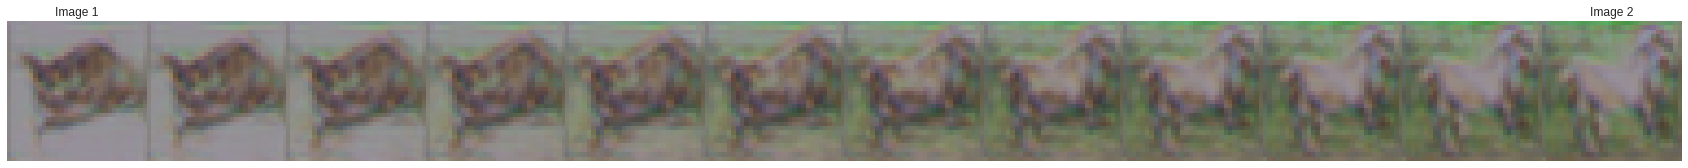

In [19]:
title = 'Conv VAE Interpolation with Perceptual Loss Fine-tuned'
model = conv_vae_trainer.model
conv_vae_trainer = Trainer(model, criterion, train_loader, valid_loader, eval_metrics, description=title, lr=0.05*LR)
conv_vae_trainer.load_model()
plot_history(conv_vae_trainer)

out = conv_vae_trainer.get_sample()
data, target, (x_hat, (z, mu, log_var)) = out
x_hat = nn.Sigmoid()(x_hat)
rand_index = np.random.randint(data.shape[0])
plt.imshow(data[rand_index].permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()
plt.imshow(x_hat.detach()[rand_index].permute(1, 2, 0).cpu())
plt.axis('off')
plt.show()

img1, _ = validset[0]
img2, _ = validset[13]

plt.subplot(1,2,1)
plt.imshow(img1.unsqueeze(0).squeeze().permute(1, 2, 0))
plt.axis("off")
plt.title("Image 1")
plt.subplot(1,2,2)
plt.imshow(img2.unsqueeze(0).squeeze().permute(1, 2, 0))
plt.axis("off")
plt.title("Image 2")
plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
with torch.no_grad():
    encoded = conv_vae_trainer.model.encoder(torch.stack([img1, img2]).to(device))
    mus, log_var = conv_vae_trainer.model.fc_mu(encoded), conv_vae_trainer.model.fc_sigma(encoded)
std = torch.exp(0.5*log_var)
latents = mus + std
latent1, latent2 = latents[0], latents[1]

decoded_imgs = sample_interpolation(conv_vae_trainer.model, latent2, latent1, N=12)
decoded_imgs = nn.Sigmoid()(decoded_imgs)

fig, ax = plt.subplots(1, len(decoded_imgs), figsize=(30,3))
for i,img in enumerate(decoded_imgs):
    ax[i].imshow(img.permute(1, 2, 0), cmap="gray")
    ax[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

plt.subplots_adjust(wspace=0., hspace=0)
ax[0].set_title("Image 1")
ax[-1].set_title("Image 2")
plt.show()